In [141]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

In [37]:
test = np.array([[1,2,3,4]]).T
test2 = np.array([[.5,1.5,3.5,4.1]]).T
t = np.hstack((test,test2))
np.minimum(test, test2)

array([[0.5],
       [1.5],
       [3. ],
       [4. ]])

In [38]:
t

array([[1. , 0.5],
       [2. , 1.5],
       [3. , 3.5],
       [4. , 4.1]])

In [40]:
df = pd.DataFrame(t, columns=['W0', 'W1'])
df

,W0,W1
0,1.0,0.5
1,2.0,1.5
2,3.0,3.5
3,4.0,4.1


In [41]:
test_vec = np.array([[1,1,3,1]]).T
test_vec

array([[1],
       [1],
       [3],
       [1]])

In [43]:
# apply fuzzy intersection element wise. 
fuzzy_int = np.minimum(test_vec,df)
fuzzy_int = np.linalg.norm( fuzzy_int, ord=1, axis=0)

,W0,W1
0,1.0,0.5
1,1.0,1.0
2,3.0,3.0
3,1.0,1.0


In [102]:
np.linalg.norm( df, ord=1, axis=0)

array([10. ,  9.6])

In [10]:

np.minimum(t, test)

array([[1. , 2. , 3. , 4. ],
       [0.5, 1.5, 3. , 4. ]])

In [13]:
np.sum(t, axis=1)

array([10. ,  9.6])

In [16]:
np.argmin(np.sum(np.minimum(t,test), axis=1))

1

In [355]:
#l1_norm = partial(np.linalg.norm, ord=1, axis=-1)
class FuzzyARTMAP:
    def __init__(self,  alpha=0.01, beta=1.0, rho=0., epsilon=0.0001, complement_coding=True):
        """
        alpha: matching parameter
        beta: learning rate
        rho: Vigilence criterion

        """
        self.alpha = alpha
        self.beta = beta
        self.rho = rho
        self.epsilon=epsilon
        self.complement_coding= complement_coding
        self.w = None
        self.w_labels = {}
        # there are no commited nodes
        self.C= -1
        self.M = None
    
    def complement_code(self, x):
        """Utility function for compliment coding of inputs"""
        if self.complement_coding:
            return np.vstack((x, 1-x))
        else:
            return x
        
    def add_category(self,x, y_label):
        """Adds an additional weight vectot w of class y """# 
        # use the weight as the examplar 
        self.C +=1
        
        self.w["W{}".format(self.C)]  =  x
        # save category label 
        self.w_labels["W{}".format(self.C)] = np.squeeze(y_label)
        
    def match_choice(self, x):
        norm_w =  np.linalg.norm( self.w, ord=1, axis=0)
        fuzzy_int = np.minimum(x,self.w)
        fuzzy_int = np.linalg.norm( fuzzy_int, ord=1, axis=0)
        # all values of T_j for j=1,...,C
        T_js = fuzzy_int + (1 - self.alpha)*(self.M * norm_w)
        vig = fuzzy_int >= self.M * self.rho
        indicies = sorted(range(len(T_js)), key=lambda k: T_js[k], reverse=True)
        return T_js, vig, indicies, fuzzy_int, norm_w
                          
                          
    
    
    def train(self, X, y, epochs = 1):
        """number of examples x number of features"""
        # initialize first weight 
        self.C = 0
        x_init = self.complement_code(X[:,0].reshape(-1,1))
        self.M = np.squeeze(X.shape[0])
        print(x_init)
        self.w = pd.DataFrame(np.ones( ( x_init.shape[0],1)), columns=["W{}".format(self.C)])
        # initialize first class
        self.w_labels["W{}".format(self.C)] = np.squeeze(y[0])
        print(self.w, self.w_labels, X)
        for epoch in range(epochs):
            for i in range(1,X.shape[1]):
                # evaulate match criterion with choice function 
                # T_j is the array of activations
                # vig is a  boolean array determining if the input satisfies the vigilence parameter
                # indicies is the sorted array of indicies
                # fuzzy int is the fuzzy intersection
                #norm_w is the norm o the weight vectors 
                satisfied = False
                # we will go until we are satisfied with a prediction 
                attempts = 0
                self.rho = 0
                A = self.complement_code(X[:,i].reshape(-1,1))
                while not satisfied:
                    attempts +=1
                    print("Attempts: {}".format(attempts))
                    T_js, vig, indicies, fuzzy_int, norm_w = self.match_choice(A)
                    
                    look= True
                    ind = -1
                    while ind < len(list(indicies)) and look:
                        ind +=1
                        index = indicies[ind]
                        if vig[index]:
                            # we have satisfied the vigilence criterion 
                            pred = self.w_labels["W{}".format(index)]
                            if pred != y[i]:
                                # Match tracking for incorrect predictions 
                                print("Wrong Prediction {}, for ground truth {}. Match tracking enabled.".format(pred, y[i]))
                                self.rho = (fuzzy_int[index]/ self.M) + self.epsilon
                                look=False
                                # we are still not satisfied 
                            else: 
                                # Resonance enabled 
                                print(" Prediction {}, for ground truth {}. Resonance enabled.".format(pred, y[i]))
                                w_old = self.w["W{}".format(index)].reshape(-1,1)
                                print("DEBUG:",A.shape, w_old.shape )
                                new_comp =   np.minimum(A, w_old)
                                self.w["W{}".format(index)] = self.beta * ( new_comp) + (1- self.beta)*w_old
                                look = False
                                satisfied = True
                                print("Updated weight  ", self.w["W{}".format(index)])
                        if ind == len(list(indicies)) -1 and look: 
                            print("No node found that satisfies Vigilence criterion. Creating a new node")
                            self.add_category(A, y[i])
                            satisfied=True
                            look=False
                            continue
                            
                                
                
                
                
    def bulk_predict(self, X):
        rets = []
        for i in range(X.shape[1]):
            A = self.complement_code(X[:,i].reshape(-1,1))
            rets +=[self.predict(A)]
        return np.array(rets)
            
    def predict(self, x):
        norm_w =  np.linalg.norm( self.w, ord=1, axis=0)
        fuzzy_int = np.minimum(x,self.w)
        fuzzy_int = np.linalg.norm( fuzzy_int, ord=1, axis=0)
        # all values of T_j for j=1,...,C
        T_js = fuzzy_int + (1 - self.alpha)*(self.M * norm_w)
        weight_index = np.argmax(   T_js )
        return self.w_labels["W{}".format(weight_index)]
        
        
        

In [322]:
net = FuzzyARTMAP()

In [323]:
test 

array([[1],
       [2],
       [3],
       [4]])

In [324]:
net.train(t, np.array([[0], [0] ]))

[[ 1.]
 [ 2.]
 [ 3.]
 [ 4.]
 [ 0.]
 [-1.]
 [-2.]
 [-3.]]
    W0
0  1.0
1  1.0
2  1.0
3  1.0
4  1.0
5  1.0
6  1.0
7  1.0 {'W0': array(0)} [[1.  0.5]
 [2.  1.5]
 [3.  3.5]
 [4.  4.1]]
Attempts: 1
 Prediction 0, for ground truth [0]. Resonance enabled.
DEBUG: (8, 1) (8, 1)
Updated weight   0    0.5
1    1.0
2    1.0
3    1.0
4    0.5
5   -0.5
6   -2.5
7   -3.1
Name: W0, dtype: float64


/Users/kbernardini/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:96: FutureWarning: reshape is deprecated and will raise in a subsequent release. Please use .values.reshape(...) instead


In [325]:
net.w_labels

{'W0': array(0)}

In [326]:
t[:,0].reshape(-1,1)

array([[1.],
       [2.],
       [3.],
       [4.]])

In [379]:
# lets test out some values
np.random.seed(69)
X = np.random.rand( 75,2)

In [380]:
X

array([[0.29624916, 0.80906772],
       [0.35025253, 0.78940926],
       [0.56134898, 0.25358895],
       [0.10497708, 0.05846073],
       [0.67329238, 0.69782966],
       [0.73278321, 0.78787406],
       [0.07637632, 0.3176806 ],
       [0.74102328, 0.32849423],
       [0.47014548, 0.18108572],
       [0.3235044 , 0.45490616],
       [0.52963052, 0.29303055],
       [0.27697515, 0.67815307],
       [0.2334587 , 0.67725537],
       [0.4323325 , 0.38766629],
       [0.33544621, 0.51322212],
       [0.98769111, 0.53091437],
       [0.68043616, 0.39113473],
       [0.1165562 , 0.70722573],
       [0.41361609, 0.45603303],
       [0.33195254, 0.09371524],
       [0.4577167 , 0.80579291],
       [0.19350921, 0.46502849],
       [0.19091752, 0.07588166],
       [0.03198771, 0.15245555],
       [0.25709202, 0.06937377],
       [0.92718944, 0.54662592],
       [0.96729604, 0.89730852],
       [0.39105022, 0.37876973],
       [0.6515744 , 0.85627836],
       [0.44305142, 0.53280211],
       [0.

In [401]:
y = ((X[:,0] **2 + X[:,1] **2) <= .4 ).astype(int)

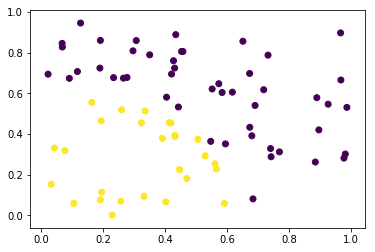

In [402]:
plt.scatter(X[:,0], X[:,1], c=y)

In [403]:
net = FuzzyARTMAP()
net.train(X.T,y, epochs=2)

[[0.29624916]
 [0.80906772]
 [0.70375084]
 [0.19093228]]
    W0
0  1.0
1  1.0
2  1.0
3  1.0 {'W0': 0} [[0.29624916 0.35025253 0.56134898 0.10497708 0.67329238 0.73278321
  0.07637632 0.74102328 0.47014548 0.3235044  0.52963052 0.27697515
  0.2334587  0.4323325  0.33544621 0.98769111 0.68043616 0.1165562
  0.41361609 0.33195254 0.4577167  0.19350921 0.19091752 0.03198771
  0.25709202 0.92718944 0.96729604 0.39105022 0.6515744  0.44305142
  0.16291775 0.12678515 0.98261237 0.76962557 0.9781755  0.67381034
  0.40467841 0.59158113 0.42083975 0.02170204 0.25948499 0.5475159
  0.4024221  0.22910881 0.19507263 0.42722154 0.71883119 0.26542901
  0.1892404  0.61748896 0.69086015 0.58431044 0.30681293 0.06714565
  0.56578411 0.89052039 0.06778207 0.8970925  0.55208882 0.96838775
  0.44686657 0.8856783  0.09049883 0.04235635 0.43453712 0.43078742
  0.41905871 0.74262951 0.57370448 0.68417231 0.5062169  0.4316559
  0.19078938 0.4532042  0.59519465]
 [0.80906772 0.78940926 0.25358895 0.05846073 0.6

/Users/kbernardini/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:96: FutureWarning: reshape is deprecated and will raise in a subsequent release. Please use .values.reshape(...) instead


Updated weight   0    0.547516
1    0.363891
2    0.309140
3    0.394216
Name: W8, dtype: float64
Attempts: 1
 Prediction 0, for ground truth 0. Resonance enabled.
DEBUG: (4, 1) (4, 1)
Updated weight   0    0.126785
1    0.674788
2    0.693187
3    0.054265
Name: W7, dtype: float64
Attempts: 1
 Prediction 0, for ground truth 0. Resonance enabled.
DEBUG: (4, 1) (4, 1)
Updated weight   0    0.067146
1    0.674788
2    0.693187
3    0.054265
Name: W7, dtype: float64
Attempts: 1
Wrong Prediction 0, for ground truth 1. Match tracking enabled.
Attempts: 2
No node found that satisfies Vigilence criterion. Creating a new node
Attempts: 1
Wrong Prediction 1, for ground truth 0. Match tracking enabled.
Attempts: 2
 Prediction 0, for ground truth 0. Resonance enabled.
DEBUG: (4, 1) (4, 1)
Updated weight   0    0.547516
1    0.363891
2    0.109480
3    0.394216
Name: W8, dtype: float64
Attempts: 1
Wrong Prediction 1, for ground truth 0. Match tracking enabled.
Attempts: 2
 Prediction 0, for ground

Wrong Prediction 0, for ground truth 1. Match tracking enabled.
Attempts: 2
 Prediction 1, for ground truth 1. Resonance enabled.
DEBUG: (4, 1) (4, 1)
Updated weight   0    0.162918
1    0.113943
2    0.740515
3    0.444841
Name: W20, dtype: float64
Attempts: 1
 Prediction 0, for ground truth 0. Resonance enabled.
DEBUG: (4, 1) (4, 1)
Updated weight   0    0.404678
1    0.581018
2    0.572778
3    0.239602
Name: W23, dtype: float64
Attempts: 1
 Prediction 0, for ground truth 0. Resonance enabled.
DEBUG: (4, 1) (4, 1)
Updated weight   0    0.021702
1    0.617643
2    0.281169
3    0.305764
Name: W25, dtype: float64
Attempts: 1
 Prediction 0, for ground truth 0. Resonance enabled.
DEBUG: (4, 1) (4, 1)
Updated weight   0    0.126785
1    0.674788
2    0.734571
3    0.054265
Name: W21, dtype: float64
Attempts: 1
 Prediction 0, for ground truth 0. Resonance enabled.
DEBUG: (4, 1) (4, 1)
Updated weight   0    0.189240
1    0.581018
2    0.572778
3    0.239602
Name: W23, dtype: float64
Attemp

In [404]:
net.w, net.w_labels

(         W0        W1        W2        W3        W4        W5        W6  \
 0  0.233459  0.076376  0.116556  0.031988  0.457717  0.443051  0.162918   
 1  0.328494  0.058461  0.391135  0.069374  0.546626  0.281278  0.113943   
 2  0.012309  0.438651  0.319564  0.586384  0.032704  0.017388  0.493783   
 3  0.210591  0.486778  0.292774  0.534972  0.102691  0.467198  0.444841   
 
          W7        W8        W9    ...          W19       W20       W21  \
 0  0.067146  0.547516  0.067782    ...     0.443051  0.162918  0.067146   
 1  0.673856  0.080791  0.581018    ...     0.281278  0.113943  0.673856   
 2  0.267217  0.109480  0.426296    ...     0.017388  0.493783  0.546796   
 3  0.054265  0.394216  0.172164    ...     0.467198  0.444841  0.054265   
 
         W22       W23       W24       W25       W26       W27       W28  
 0  0.547516  0.067782  0.229109  0.021702  0.042356  0.434537  0.552089  
 1  0.080791  0.581018  0.001008  0.617643  0.224453  0.420168  0.262035  
 2  0.10948

In [405]:
print("Done")

Done


In [406]:
preds = net.bulk_predict(X.T)

In [407]:
y

array([0, 0, 1, 1, 0, 0, 1, 0, 1, 1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 1, 0, 1,
       1, 1, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 1,
       1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0,
       1, 0, 0, 0, 1, 1, 0, 0, 0])

In [408]:
preds ^ y

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0])

In [409]:
X_test = np.random.rand( 50,2)
y_test = ((X_test[:,0] **2 + X_test[:,1] **2) <= .5 ).astype(int)

In [410]:
 test_preds = net.bulk_predict(X_test.T)

In [411]:
test_preds ^ y_test # Not bad!


array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0,
       0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0,
       0, 1, 0, 0, 0, 0])

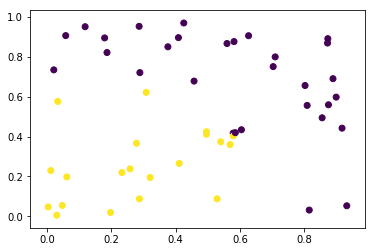

In [412]:
plt.scatter(X_test[:,0], X_test[:,1], c=y_test)

In [413]:
xx, yy = np.mgrid[0:1.01:.01, 0:1.01:.01]
grid = np.c_[xx.ravel(), yy.ravel()]
probs = net.bulk_predict(grid.T).reshape(xx.shape)

[(0, 1), Text(0,0.5,'$X_2$'), (0, 1), Text(0.5,0,'$X_1$'), None]

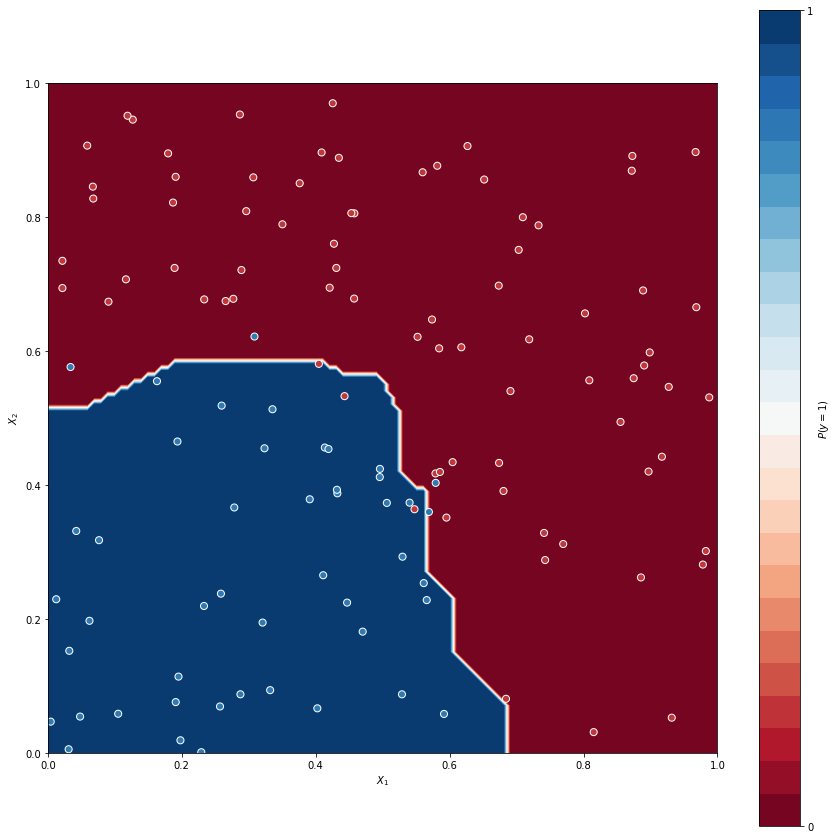

In [416]:
f , ax = plt.subplots(figsize=(15, 15))
contour = ax.contourf(xx, yy, probs, 25, cmap="RdBu",
                      vmin=0, vmax=1)
ax_c = f.colorbar(contour)
ax_c.set_label("$P(y = 1)$")
ax_c.set_ticks([0,  1])


ax.scatter(X[:,0], X[:, 1], c=y, s=50,
           cmap="RdBu", vmin=-.2, vmax=1.2,
           edgecolor="white", linewidth=1)

ax.scatter(X_test[:,0], X_test[:, 1], c=y_test, s=50,
           cmap="RdBu", vmin=-.2, vmax=1.2,
           edgecolor="white", linewidth=1)

ax.set(aspect="equal",
       xlim=(0, 1), ylim=(0, 1),
       xlabel="$X_1$", ylabel="$X_2$")

In [ ]:
#l1_norm = partial(np.linalg.norm, ord=1, axis=-1)
class KernelARTMAP:
    def __init__(self,  alpha=0.01, beta=1.0, rho=0., epsilon=0.0001, complement_coding=True):
        """
        alpha: matching parameter
        beta: learning rate
        rho: Vigilence criterion

        """
        self.alpha = alpha
        self.beta = beta
        self.rho = rho
        self.epsilon=epsilon
        self.complement_coding= complement_coding
        self.w = None
        self.w_labels = {}
        # there are no commited nodes
        self.C= -1
        self.M = None
    
    def add_category(self,x, y_label):
        """Adds an additional weight vectot w of class y """# 
        # use the weight as the examplar 
        self.C +=1
        
        self.w["W{}".format(self.C)]  =  x
        # save category label 
        self.w_labels["W{}".format(self.C)] = np.squeeze(y_label)
        
    def match_choice(self, x):
        norm_w =  np.linalg.norm( self.w, ord=1, axis=0)
        fuzzy_int = np.minimum(x,self.w)
        fuzzy_int = np.linalg.norm( fuzzy_int, ord=1, axis=0)
        # all values of T_j for j=1,...,C
        T_js = fuzzy_int + (1 - self.alpha)*(self.M * norm_w)
        vig = fuzzy_int >= self.M * self.rho
        indicies = sorted(range(len(T_js)), key=lambda k: T_js[k], reverse=True)
        return T_js, vig, indicies, fuzzy_int, norm_w
                          
                          
    
    
    def train(self, X, y, epochs = 1):
        """number of examples x number of features"""
        # initialize first weight 
        self.C = 0
        x_init = self.complement_code(X[:,0].reshape(-1,1))
        self.M = np.squeeze(X.shape[0])
        print(x_init)
        self.w = pd.DataFrame(np.ones( ( x_init.shape[0],1)), columns=["W{}".format(self.C)])
        # initialize first class
        self.w_labels["W{}".format(self.C)] = np.squeeze(y[0])
        print(self.w, self.w_labels, X)
        for epoch in range(epochs):
            for i in range(1,X.shape[1]):
                # evaulate match criterion with choice function 
                # T_j is the array of activations
                # vig is a  boolean array determining if the input satisfies the vigilence parameter
                # indicies is the sorted array of indicies
                # fuzzy int is the fuzzy intersection
                #norm_w is the norm o the weight vectors 
                satisfied = False
                # we will go until we are satisfied with a prediction 
                attempts = 0
                self.rho = 0
                A = X[:,i].reshape(-1,1)
                while not satisfied:
                    attempts +=1
                    print("Attempts: {}".format(attempts))
                    T_js, vig, indicies, fuzzy_int, norm_w = self.match_choice(A)
                    
                    look= True
                    ind = -1
                    while ind < len(list(indicies)) and look:
                        ind +=1
                        index = indicies[ind]
                        if vig[index]:
                            # we have satisfied the vigilence criterion 
                            pred = self.w_labels["W{}".format(index)]
                            if pred != y[i]:
                                # Match tracking for incorrect predictions 
                                print("Wrong Prediction {}, for ground truth {}. Match tracking enabled.".format(pred, y[i]))
                                self.rho = (fuzzy_int[index]/ self.M) + self.epsilon
                                look=False
                                # we are still not satisfied 
                            else: 
                                # Resonance enabled 
                                print(" Prediction {}, for ground truth {}. Resonance enabled.".format(pred, y[i]))
                                w_old = self.w["W{}".format(index)].reshape(-1,1)
                                print("DEBUG:",A.shape, w_old.shape )
                                new_comp =   np.minimum(A, w_old)
                                self.w["W{}".format(index)] = self.beta * ( new_comp) + (1- self.beta)*w_old
                                look = False
                                satisfied = True
                                print("Updated weight  ", self.w["W{}".format(index)])
                        if ind == len(list(indicies)) -1 and look: 
                            print("No node found that satisfies Vigilence criterion. Creating a new node")
                            self.add_category(A, y[i])
                            satisfied=True
                            look=False
                            continue
                            
                                
                
                
                
    def bulk_predict(self, X):
        rets = []
        for i in range(X.shape[1]):
            A = self.complement_code(X[:,i].reshape(-1,1))
            rets +=[self.predict(A)]
        return np.array(rets)
            
    def predict(self, x):
        norm_w =  np.linalg.norm( self.w, ord=1, axis=0)
        fuzzy_int = np.minimum(x,self.w)
        fuzzy_int = np.linalg.norm( fuzzy_int, ord=1, axis=0)
        # all values of T_j for j=1,...,C
        T_js = fuzzy_int + (1 - self.alpha)*(self.M * norm_w)
        weight_index = np.argmax(   T_js )
        return self.w_labels["W{}".format(weight_index)]
        
        
        